## Linguistic Feature Extraction with Spacy using ADDRESSO 2021 data

- Lexical features
- Syntactic features
- Features of cohesion
- Readability features

In [ ]:
import csv
import os
import sys
import sox
from lexicalrichness import LexicalRichness
import shutil
from operator import itemgetter
from itertools import groupby
import numpy as np
import shutil 
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
import spacy
import en_core_web_sm
import glob
from spacy.matcher import Matcher
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [4]:
path = '/export/b15/rpapagari/Tianzi_work/ADReSSo_NoVAD_IS2021_dataset/data_ADReSSo_diagnosis_cv10_text_v7_Longformer_TrainDevTest/cv_6/utt2csvpath'
train = '/export/b15/rpapagari/Tianzi_work/ADReSSo_NoVAD_IS2021_dataset/data_ADReSSo_diagnosis_cv10_text_v7_Longformer_TrainDevTest/cv_6/train.tsv'
dev = '/export/b15/rpapagari/Tianzi_work/ADReSSo_NoVAD_IS2021_dataset/data_ADReSSo_diagnosis_cv10_text_v7_Longformer_TrainDevTest/cv_6/dev.tsv'
test = '/export/b15/rpapagari/Tianzi_work/ADReSSo_NoVAD_IS2021_dataset/data_ADReSSo_diagnosis_cv10_text_v7_Longformer_TrainDevTest/cv_6/test.tsv'

In [5]:
#pd.read_csv(test)

In [6]:
def data_to_csv(path_trans, train, dev, test):
    
    path_ordered = []
    sentences = []
    
    read_train = pd.read_csv(train, header=None)
    read_dev = pd.read_csv(dev, header=None)
    read_test = pd.read_csv(test, header=None)
    data = pd.concat([read_train, read_dev, read_test], ignore_index=True)
    
    read_trans = pd.read_csv(path_trans, header=None)
    patients = (data[0].tolist())
    labels = (data[1].tolist())
    path_to_transcript= read_trans[1].tolist()
    
    for patient in patients:
        for path in path_to_transcript:
            if os.path.basename(path).split('.csv')[0] == patient:
                path_ordered.append(path)
                
    for transcript in path_ordered:
        with open(transcript, 'r') as f:
            transcript_ = f.readlines()
        #print(transcript_)
            transcript_ = transcript_[0]
            sentences.append(transcript_)

            
    
    dict = {'idx': patients, 'label': labels, 'sentence': sentences} 
    df = pd.DataFrame(dict)
    return df
    
    


In [7]:
df = data_to_csv(path, train, dev, test)


## Pre-Processing 

We perform the following preprocessing steps:

- **Convert all words to lowercase**. This is important for matching certain phrases later on, where the matching is case-sensitive and the word or phrase of interest would not be matched to a capitalized version of the same word or phrase.

- **Tokenize the data**. This step refers to identifying the boundaries of individual words and sentences within each item.

- **Lemmatization**. This process converts each word to its base form (e.g. 'has' to 'have', 'are' to 'be') for the purpose of easier matching.

- **Removal of words that contain non-alphabetic characters** (e.g., numbers, '#', '@', etc.)

- **Stopword removal**. This step refers to the removal of words that may not be important for the analysis (e.g. 'a', 'an', 'the', etc.). One could use a predefined list of stopwords (usually these remove all forms of the verb 'to be', as well as pronouns) or create a customized list of stopwords depending on what is important for the specific application.

In [8]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
    return list_object


In [9]:
def holm_correction(kruskal):
    line_to_remove=[]
    values=[]
    corrected =[]
    final = []
    for l in kruskal:
        if "nan" in l:
            line_to_remove.append(kruskal.index(l))
    
    new_krusk = delete_multiple_element(kruskal, line_to_remove)
            
    for line in new_krusk:
        ok = line.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(float(num))
   # values = [x for x in values if isnan(x) == False]
    result = statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)
    num = np.where(result[0] == True)
    list_index = ((num)[0]).tolist()

    for i in list_index:
        corrected.append(result[1][i])
    for i in list_index:
        final.append(kruskal[i])
    
    return final, corrected
    
    
    #return values
#val = np.array(values)
    #return statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)

In [10]:
def compute_lexical_diversity(transcript):
    
    lex = LexicalRichness(transcript)
   # word_count = lex.words
    unique_word_count =  lex.terms
    type_token_ratio = lex.ttr
   # root_type_token_ratio = lex.rttr
    corrected_type_token_ratio = lex.cttr
   # mean_segmental_type_token_ratio = lex.msttr(segment_window=12) #25
    moving_average_type_token_ratio = lex.mattr(window_size=13) #25
   # measure_textual_lexical_diversity= lex.mtld(threshold=0.72)
   # hypergeometric_distribution_diversity = lex.hdd(draws=13)
   # herdan_lexical_diversity_measure = lex.Herdan
    summer_lexical_diversity_measure=lex.Summer
    dugast_lexical_diversity_measure =lex.Dugast
   # maas_lexical_diversity_measure = lex.Maas
    
    return unique_word_count, type_token_ratio, corrected_type_token_ratio, moving_average_type_token_ratio, summer_lexical_diversity_measure, dugast_lexical_diversity_measure
    

           

In [11]:
def load_files(data):
    
    speakers = data['idx'].tolist()
    sentences = data['sentence'].tolist()
    labels = data['label'].tolist()
    lex_vals = np.array([compute_lexical_diversity(sent) for sent in sentences])
    names = ["unique_word_count", "type_token_ratio", "corrected_type_token_ratio", "moving_average_type_token_ratio", "summer_lexical_diversity_measure", "dugast_lexical_diversity_measure"]
    frame = pd.DataFrame({"speakers": speakers, "labels": labels, "sentences": sentences, **{name:val for name, val in zip(names,lex_vals.T)}})
    return frame
    


In [14]:
df = load_files(df)

In [15]:
#load the Spacy model for extracting data for English: "en_core_web_sm" 
nlp = spacy.load('en_core_web_sm')

In [17]:
df

,speakers,labels,sentences,unique_word_count,type_token_ratio,corrected_type_token_ratio,moving_average_type_token_ratio,summer_lexical_diversity_measure,dugast_lexical_diversity_measure
0,adrso093,ad,"""Honey, what's going on in that picture? This ...",87.0,0.462766,4.486682,0.867570,0.903862,35.586139
1,adrso247,ad,"""okay. Oh, Oh, boys are getting in the cookies...",72.0,0.642857,4.810702,0.914615,0.936631,50.390632
2,adrso078,ad,"""conversation. Mhm. Well, yes. Yes. Jim. Still...",71.0,0.657407,4.830938,0.906250,0.939203,52.264352
3,adrso233,ad,"""And here's the picture. Mhm, mhm. Kids still ...",91.0,0.654676,5.457817,0.947305,0.943769,57.479235
4,adrso106,ad,"""what's going on in the picture? Yeah, well, t...",68.0,0.489209,4.078369,0.870382,0.901940,34.056200
...,...,...,...,...,...,...,...,...,...
161,adrso259,cn,"""mhm test picture. Mhm. Alright, then alright....",106.0,0.527363,5.286799,0.903948,0.922931,43.954595
162,adrso260,cn,"""then we can begin right there. No. Well, the ...",66.0,0.694737,4.788143,0.947173,0.945012,56.937215
163,adrso261,cn,"""a boy being one hand and this hand in the coo...",64.0,0.703297,4.743996,0.919182,0.946072,57.810274
164,adrso262,cn,"""you can start there. Okay. Uh, the mother is ...",54.0,0.701299,4.351444,0.926627,0.941982,53.177872


In [16]:
#lower case the transcript 
df['sentence'] = df['sentence'].str.lower()

KeyError: 'sentence'

In [ ]:
# Create a function to preprocess the text

#Customized list of stopwords 
stopwords = ['a', 'an', 'the', 'with', 'to', 'be', 'have', 'for', 'has']

def preprocess(text):
    '''This is a function to perform tokenization, lemmatization, removal of non-alphabetic characters
    and stopword removal'''
  # Create Doc object
    doc = nlp(text, disable=['ner'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    return ' '.join(a_lemmas)

In [12]:

df['Item'] = df['sentence'].apply(preprocess)
#df.head()

# Shallow Features

First, the extraction of each feature type is defined as a function. The function is then applied to the item text and the output is stored in a new variable. Depending on the type of information needed, the function may be applied to the raw text (sentence) or to the preprocessed text ("Item"). For example, applying a word-count function to the raw text will return the full word count, while applying it to the preprocessed text will return the number of content words, after stopwords have been removed.

## Count Words

In [13]:
def count_words(string):
    '''This function returns the number of words in a string'''
    # Split the string into words
    words = string.split()
    # Return the number of words
    return len(words)

#Application to the raw data to get the full word count

df['Word_Count'] = df['sentence'].apply(count_words)

#Application to the preprocessed data to get the content-word count

df['Word_Count_No_stop_words'] = df['Item'].apply(count_words)
df.head()


,idx,label,sentence,Item,Word_Count,Word_Count_No_stop_words
0,adrso093,ad,"""honey, what's going on in that picture? this ...",honey what go on in that picture this little b...,174,161
1,adrso247,ad,"""okay. oh, oh, boys are getting in the cookies...",okay oh oh boy get in cookie he climb up chair...,102,88
2,adrso078,ad,"""conversation. mhm. well, yes. yes. jim. still...",conversation mhm well yes yes jim still in wat...,102,85
3,adrso233,ad,"""and here's the picture. mhm, mhm. kids still ...",and here picture mhm mhm kid still turn over t...,135,116
4,adrso106,ad,"""what's going on in the picture? yeah, well, t...",what go on in picture yeah well water run out ...,131,105


### Word Length

In [14]:
def word_length(string):
    '''This function returns the average word length in characters for the words in an item'''
    #Get the length of the full text in characters
    chars = len(string)
    #Split the string into words
    words = string.split()
    #Compute the average word length and round the output to the second decimal point
    avg_word_length = chars/len(words)
    return round(avg_word_length, 2)

#Application to the preprocessed data

df['Avg_Word_Length'] = df['Item'].apply(word_length)
#df.head()

### Sentence Counter

In [15]:
def sentence_counter(text):
    '''This function returns the number of sentences in an item'''
    doc = nlp(text)
    #Initialize a counter variable
    counter = 0
    #Update the counter for each sentence which can be found in the doc.sents object returned by the Spacy model
    for sentence in doc.sents:
        counter = counter + 1
    return counter

#Note that this function is applied to the raw text in order to identify sentence boundaries

df['Sentence_Count'] = df['sentence'].apply(sentence_counter)
#df.head()

### Average Sentence Lenght in Words

In [16]:
def avg_sent_length(text):
    '''This function returns the average sentence length in an item'''
    doc = nlp(text)
    #Initialize a counter variable
    sent_number = 0
    #Update the counter for each sentence which can be found in the doc.sents object returned by the Spacy model
    for sent in doc.sents:
        sent_number = sent_number + 1
    #Get the number of words
    words = text.split()
    #Compute the average sentence length and round it to the second decimal point
    avg_sent_length = len(words)/sent_number
    return round(avg_sent_length, 2)

#Note that this function is applied to the raw text in order to identify sentence boundaries
df['Avg_Sentence_Length_in_Words'] = df['sentence'].apply(avg_sent_length)
#df.head()

# Syntactic Features

https://spacy.io/usage/linguistic-features#pos-tagging

### Noun Count

In [17]:
def nouns(text, model=nlp):
    '''This function returns the number of nouns in an item'''
    # Create doc object 
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of nouns
    return pos.count('NOUN')

df['Noun_Count'] = df['Item'].apply(nouns)
#df.head()

### Verb Count

In [18]:
def verbs(text, model=nlp):
    '''This function returns the number of verbs in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of verbs
    return pos.count('VERB')

df['Verb_Count'] = df['Item'].apply(verbs)

#df.head()


### Adjective Count 

In [19]:
def adjectives(text, model=nlp):
    '''This function returns the number of adjectives in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adjectives
    return pos.count('ADJ')

df['Adjective_Count'] = df['Item'].apply(adjectives)

#df.head()

### Adverb Count

In [20]:
def adverbs(text, model=nlp):
    '''This function returns the number of adverbs in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adverbs
    return pos.count('ADV')

df['Adverb_Count'] = df['Item'].apply(adverbs)
#df.head()

### Numeral Count

In [21]:
def numeral(text, model=nlp):
    '''This function returns the number of numerals (e.g., billion) in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adverbs
    return pos.count('NUM')

df['Numeral Count'] = df['sentence'].apply(numeral) #meglio estrarlo dall'originale
#df.head()

### Auxiliary Count

In [22]:
def aux(text, model=nlp):
    '''This function returns the number of auxiliary in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adverbs
    return pos.count('AUX')

df['Auxiliary_Count'] = df['sentence'].apply(aux) #meglio estrarlo dall'originale
#df.head()

### Number Noun Phrases

In [23]:
def get_nps(text):
    '''This is a function that outputs the number of noun phrases in an item'''
    doc = nlp(text)
    NP_count = 0
    for np in doc.noun_chunks:
        NP_count = NP_count + 1
    return NP_count
    #print(np)

df['Number_of_NPs'] = df['Item'].apply(get_nps)
#df.head()

### Number Prepositioanal Phrases

In [24]:
def get_pps(text):
    '''This is a function that outputs the number of prepositional phrases in an item'''
    doc = nlp(text)
    pps = 0
    for token in doc:
        # You can try this with other parts of speech for different subtrees.
        if token.pos_ == 'ADP':
            
            #Use the command below if you wanted to get the actual PPs
            #pp = ' '.join([tok.orth_ for tok in token.subtree])
            
            #This command counts the number of PPs
            pps = pps + 1
            
    return pps

df['Number_of_PPs'] = df['Item'].apply(get_pps)
#df.head()

### Number Verb Phrases

In [25]:
pattern = [{'POS': 'VERB', 'OP': '?'},
           {'POS': 'ADV', 'OP': '*'},
           {'POS': 'AUX', 'OP': '*'},
           {'POS': 'VERB', 'OP': '+'}]


def get_vps(text):
    '''This function returns the number of verb phrases in an item'''
    doc = nlp(text)
    vps = 0
    # instantiate a Matcher instance
    matcher = Matcher(nlp.vocab)
    matcher.add("Verb phrase", [pattern], on_match=None) #new syntax of the command
    # call the matcher to find matches 
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    for match in matches:
        vps = vps +1
    return vps
    
df['Number_of_VPs'] = df['Item'].apply(get_vps)
#df.head()

### Features of Cohesion

Cohesion generally refers to the presence or absence of explicit cues in the text that allow the reader to make connections between the ideas in the text (Crossley, Kyle and McNamara, 2016). Thus, features of cohesion are useful in eassay scoring and readability research.

A useful resource for further reading on cohesion can be found here: https://link.springer.com/article/10.3758/s13428-015-0651-7




In [26]:
#First, we create lists of different types of connectives that we will later match to the text

#Connectives to instruct, recount and sequence
temporal_connectives = ['afterwards', 'once', 'at this moment', 'at this point', 'before', 'finally', 
                        'here', 'in the end', 'lastly', 'later on', 'meanwhile', 'next', 'now', 
                        'on another occasion', 'previously','since', 'soon', 'straightaway', 'then', 
                        'when', 'whenever', 'while']


#Connectives to show cause or conditions
causal_connectives = ['accordingly', 'all the same', 'an effect of', 'an outcome of', 'an upshot of',
                      'as a consequence of', 'as a result of', 'because', 'caused by', 'consequently',
                      'despite this', 'even though', 'hence', 'however', 'in that case', 'moreover',
                      'nevertheless', 'otherwise', 'so', 'so as', 'stemmed from', 'still', 'then',
                      'therefore', 'though', 'under the circumstances', 'yet']


#Connectives for showing results
exemplifying_connectives = ['accordingly', 'as a result', 'as exemplified by', 'consequently', 'for example',
                            'for instance', 'for one thing', 'including', 'provided that', 'since', 'so',
                            'such as', 'then', 'therefore', 'these include', 'through', 'unless', 'without']


#Connectives to show similarity or add a point
additive_connectives = ['and', 'additionally', 'also', 'as well', 'even', 'furthermore', 'in addition', 'indeed',
                        'let alone', 'moreover', 'not only']

#Connectives showing a difference or an opposite point of view
contrastive_connectives = ['alternatively', 'anyway', 'but', 'by contrast', 'differs from', 'elsewhere',
                           'even so', 'however', 'in contrast', 'in fact', 'in other respects', 'in spite of this',
                           'in that respect', 'instead', 'nevertheless', 'on the contrary', 'on the other hand',
                           'rather', 'though', 'whereas', 'yet']

### Temporal Connectives Count

In [27]:
def temporal_connectives_count(text):
    '''This function counts the number of temporal connectives in a text'''
    count = 0
    for string in temporal_connectives:
        for match in re.finditer(string, text):
            count +=  1
    return count

#Note that we apply the function to the raw text (and remember that it is important to lowercase all words)
df['Temporal_Connectives_Count'] = df['sentence'].apply(temporal_connectives_count)
#df.head()


### Causal Connectives Count

In [28]:
def causal_connectives_count(text):
    '''This function counts the number of causal connectives in a text'''
    count = 0
    for string in causal_connectives:
        for match in re.finditer(string, text):
            count +=  1
    return count

df['Causal_Connectives_Count'] = df['sentence'].apply(causal_connectives_count)
#df.head()

### Exemplifying Connectives Count

In [29]:
def exemplifying_connectives_count(text):
    '''This function counts the number of exemplifying connectives in a text'''
    count = 0
    for string in exemplifying_connectives:
        for match in re.finditer(string, text):
            count +=  1
    return count

df['Exemplifying_?Connectives_Count'] = df['sentence'].apply(exemplifying_connectives_count)
#df.head()

### Additive Connectives Count

In [30]:
def additive_connectives_count(text):
    '''This function counts the number of additive connectives in a text'''
    count = 0
    for string in additive_connectives:
        for match in re.finditer(string, text):
            count +=  1
    return count

df['Additive_Connectives_Count'] = df['sentence'].apply(additive_connectives_count)
#df.head()

### Contrastive connectives Count

In [31]:
def contrastive_connectives_count(text):
    '''This function counts the number of contrastive connectives in a text'''
    cont_con = 0
    for string in contrastive_connectives:
        if string in text:
            cont_con = cont_con + 1
    return cont_con

df['Contrastive_Connectives_Count'] = df['sentence'].apply(contrastive_connectives_count)
#df.head()


In [32]:
filled_pause = ["uhm"]
    

def filled_pauses(text):
    
    cont_pauses = 0
    for string in filled_pause:
        for match in re.finditer(string, text):
            cont_pauses += 1
    return cont_pauses

df['Filled_Pauses'] = df['sentence'].apply(filled_pauses)
#df[:40]

In [33]:
def certanty(text):
    
    '''Function design to capture the level of certainty of patients in providing the description
    of the image. To operationalize uncertanty I chose modals verbs as cue and interrogative marks. '''
    
    cont_con = 0
    if "?" in text:
        cont_con = cont_con + 1
    if "why" in text:
        cont_con = cont_con + 1
    if "might" in text:
        cont_con = cont_con + 1
    if "can" in text:
        cont_con = cont_con + 1
    if "may" in text:
        cont_con = cont_con + 1
    if "sure" in text:
        cont_con = cont_con + 1     
   # if "I" in text:
      #  cont_con = cont_con + 1 
    if "uhm" in text:
        cont_con = cont_con + 1 
    if "ah" in text:
        cont_con = cont_con + 1 
    if "should" in text:
        cont_con = cont_con + 1 
    if "looks like" in text:
        cont_con = cont_con + 1
        
    
    return cont_con

df['certanty'] = df['sentence'].apply(certanty)

In [34]:

def repetitions(text):
     
    '''Function design to capture the redundancy in the code.  To operationalize 
    redundancy I chose to count the repetitions. '''
    
    
    repetition = 0
    
    text = text.split()
    d = dict()
    
    for line in text:
        line = line.strip()
        line = line.lower()
        words = line.split(" ")
        for word in words:

            if word in d:
                d[word] = d[word] + 1
            else:
                d[word] = 1
    
    for key in list(d.keys()):
        if key != 'the' and key != "a" and key != "of" and key != "to" and key !="on" and key !="is" and key !="are" and key !="in" and key != "an":
            if d[key] > 1:
                repetition +=1

    return repetition


df['repetition'] = df['sentence'].apply(repetitions)


In [35]:
def informational_verb(text):
    
    '''Exhaustivness of the description operationalized by 
    counting how many (if any) salient items (nouns) are mentioned. '''
    
    cont_con = 0
    
    if "washing" in text:
        cont_con = cont_con + 1
    if "overflowing" in text:
        cont_con = cont_con + 1
    if "hanging" in text:
        cont_con = cont_con + 1
    if "falling" in text:
        cont_con = cont_con + 1
    if "wearing" in text:
        cont_con = cont_con + 1
    if "running" in text:
        cont_con = cont_con + 1
    if "drying" in text:
        cont_con = cont_con + 1
    if "paying attention" in text:
        cont_con = cont_con + 1
    if "reaching" in text:
        cont_con = cont_con + 1
    if "tipping" in text:
        cont_con = cont_con + 1

    
    return cont_con

df['informational_verb'] = df['sentence'].apply(informational_verb)

In [36]:
def informational_content(text):

    '''Exhaustivness of the description operationalized by 
    counting how many (if any) salient actions (verbs) are mentioned. '''

    
    cont_con = 0
    
    if "mother" in text:
        cont_con = cont_con + 1
    if "sister" in text:
        cont_con = cont_con + 1
    if "cookie" in text:
        cont_con = cont_con + 1
    if "cookie jar" in text:
        cont_con = cont_con + 1
    if "curtains" in text:
        cont_con = cont_con + 1
    if "cabinet" in text:
        cont_con = cont_con + 1
    if "brother" in text:
        cont_con = cont_con + 1
    if "kitchen" in text:
        cont_con = cont_con + 1
    if "sink" in text:
        cont_con = cont_con + 1
    if "garden" in text:
        cont_con = cont_con + 1
    if "fall" in text:
        cont_con = cont_con + 1
    if "dishes" in text:
        cont_con = cont_con + 1     
    if "stool" in text:
        cont_con = cont_con + 1 
    if "poddle" in text:
        cont_con = cont_con + 1 
    
    return cont_con

df['informational'] = df['sentence'].apply(informational_content)

In [31]:
#df = df.rename(columns={"informational content (events)": "Informativeness [events]\nCTP task"})
#df = df.rename(columns={"Informational content (entities)": "Informativeness [entities]\nCTP task"})
#df = df.rename(columns={"ratio informativeness - repetition+uncertainty": "Ratio Inf-Repet\nCTP task"})
##df = df.rename(columns={"Avg_Word_Length": "Word length [char]\nCTP task"})
###combined_csv_data = combined_csv_data.rename(columns={"F0std":"F0 [Hz] (σ)\nCTP task"})
#df = df.rename(columns={"Number_of_NPs": "# NP(s)\nCTP task"})
#df = df.rename(columns={"Number_of_PPs": "# PP(s)\nCTP task"})

In [33]:
df_export = df.to_csv('/export/b15/afavaro/Frontiers/submission/Classification/ADR_2021_feats/linguistic_address0_2021.csv', index=False)
#df_export = df.to_csv('/export/b14/afavaro/LexicalRichness/Lexical, Syntactic, and Cohesion Features Output.csv', index=False)

#df_long_items_export = df_long_items.to_csv('/export/b14/afavaro/LexicalRichness/Readability Features Output.csv', index=False)





# STATISTICAL ANALYSIS 

In [12]:

data_frame_ling_feat = pd.read_csv('/export/b14/afavaro/LexicalRichness/linguistic_address0_2021.txt')
#data_frame_readabilty = pd.read_csv('/export/b14/afavaro/LexicalRichness/Readability Features Output.csv')


In [13]:
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Avg_Word_Length": "Word length [char]\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Sentence_Count": "# sentence(s)\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Avg_Sentence_Length_in_Words": "Sentence length [words]\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Avg_Word_Length": "Word length [char]\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Noun_Count": "# noun(s)\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Adverb_Count": "# adjectives(s)\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Adverb_Count": "# adverb(s)\nCTP task (ADR)"})
#data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Numeral Count": "# numeral(s)\nCTP task (ADR)"})
data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Contrastive_Connectives_Count": "# contrastive connectives(s)\nCTP task (ADR)"})


### 1) LINGUISTIC FEATS 

In [92]:
#data_frame_ling_feat.head()

In [15]:
grouped = data_frame_ling_feat.groupby("label") #here we extract the values by category
control = grouped.get_group("cn")
alzheimer = grouped.get_group("ad")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [16]:
task = data_frame_ling_feat.columns[4:].values.tolist()
control_all_feat = np.array([control[feat] for feat in np.array(data_frame_ling_feat.columns[4:])])
alzheimer_all_feat = np.array([alzheimer[feat] for feat in np.array(data_frame_ling_feat.columns[4:])])

In [95]:
#data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Avg_Word_Length": "Word length [char]\nCTP task"})
#data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Sentence_Count": "# sentence(s)\nCTP task"})
#data_frame_ling_feat = data_frame_ling_feat.rename(columns={"Avg_Sentence_Length_in_Words": "Sentence length [words]\nCTP task (ADR)"})
#df = df.rename(columns={"Avg_Word_Length": "Word length [char]\nCTP task"})
##combined_csv_data = combined_csv_data.rename(columns={"F0std":"F0 [Hz] (σ)\nCTP task"})
#df = df.rename(columns={"Number_of_NPs": "# NP(s)\nCTP task"})
#df = df.rename(columns={"Number_of_PPs": "# PP(s)\nCTP task"})

## Running Statistical Tests

### T-Test

### Kruskal–Wallis test

In [135]:
def kruskal(f, task, c, p, c_name, p_name):
    for i, title in enumerate(task):
        nome = title
        f.write(('\n'+ f'kruskal results for {title} {c_name} {p_name} {stats.kruskal(c[i], p[i])} \n\n'))

with open('/export/b14/afavaro/LexicalRichness/results_kruskal-syntax_semantic_rich_new.txt', 'w') as f:
    
    kruskal(f, task, alzheimer_all_feat, control_all_feat, "alzheimers vs.", "controls")

In [136]:
def read_stats_test(file):
    
    with open(file, 'r') as f:
        lista = []
        testo = f.readlines()
        testo = [line.strip("\n") for line in testo]

        for line in testo:
            if line=="":
                pass
            else:
                lista.append(line)
                
    return lista
    

In [137]:
kruskal_1 = read_stats_test('/export/b14/afavaro/LexicalRichness/results_kruskal-syntax_semantic_rich_new.txt')
#kruskal_1_ = read_stats_test('/export/b14/afavaro/LexicalRichness/addresso2021_results_kruskal-lexical_rich_.txt')

In [138]:
kruskal_1

['kruskal results for Word_Count alzheimers vs. controls KruskalResult(statistic=1.187507451483989, pvalue=0.2758329100088612) ',
 'kruskal results for Word_Count_No_stop_words alzheimers vs. controls KruskalResult(statistic=0.06692544566746626, pvalue=0.7958670839490196) ',
 'kruskal results for Avg_Word_Length alzheimers vs. controls KruskalResult(statistic=26.21007683715526, pvalue=3.062204261476518e-07) ',
 'kruskal results for Sentence_Count alzheimers vs. controls KruskalResult(statistic=11.036203228891369, pvalue=0.0008934966509648527) ',
 'kruskal results for Avg_Sentence_Length_in_Words alzheimers vs. controls KruskalResult(statistic=26.398643243006397, pvalue=2.777355009555781e-07) ',
 'kruskal results for Noun_Count alzheimers vs. controls KruskalResult(statistic=19.872267324330554, pvalue=8.279269619282109e-06) ',
 'kruskal results for Verb_Count alzheimers vs. controls KruskalResult(statistic=0.13627541428563644, pvalue=0.7120121951540659) ',
 'kruskal results for Adjectiv

In [71]:
holm_correction(kruskal_1+ kruskal_1_)

(['kruskal results for Avg_Word_Length alzheimers vs. controls 3.062204261476518e-07 ',
  'kruskal results for Sentence_Count alzheimers vs. controls 0.0008934966509648527 ',
  'kruskal results for Avg_Sentence_Length_in_Words alzheimers vs. controls 2.777355009555781e-07 ',
  'kruskal results for Noun_Count alzheimers vs. controls 8.279269619282109e-06 ',
  'kruskal results for Adjective_Count alzheimers vs. controls 0.000976151628167875 ',
  'kruskal results for Adverb_Count alzheimers vs. controls 0.020761445466979705 ',
  'kruskal results for Numeral Count alzheimers vs. controls 0.0014794295026365084 ',
  'kruskal results for Contrastive_Connectives_Count alzheimers vs. controls 0.024066471563845924 ',
  'kruskal results for unique_word_count controls vs. alzheimer 0.0014528060481709681 ',
  'kruskal results for root_type_token_ratio controls vs. alzheimer 6.7152734417244355e-06 ',
  'kruskal results for corrected_type_token_ratio controls vs. alzheimer 6.818219276792633e-06 ',
  

In [140]:
task

['Word_Count',
 'Word_Count_No_stop_words',
 'Avg_Word_Length',
 'Sentence_Count',
 'Avg_Sentence_Length_in_Words',
 'Noun_Count',
 'Verb_Count',
 'Adjective_Count',
 'Adverb_Count',
 'Numeral Count',
 'Auxiliary_Count',
 'Number_of_NPs',
 'Number_of_PPs',
 'Number_of_VPs',
 'Temporal_Connectives_Count',
 'Causal_Connectives_Count',
 'Exemplifying_?Connectives_Count',
 'Additive_Connectives_Count',
 'Contrastive_Connectives_Count']

In [139]:
compute_auc(control_all_feat, alzhiemer_all_feat)

0.55
0.51
0.73
0.65
0.73
0.7
0.52
0.65
0.6
0.63
0.56
0.51
0.53
0.51
0.55
0.55
0.58
0.54
0.59


In [72]:

import numpy as np
from sklearn import metrics
import sklearn


def compute_auc(array_1, array_2):
    xs = np.concatenate([array_1, array_2],axis=1)
    y = np.concatenate([array_1.shape[1]*[2], array_2.shape[1]*[1]])
    
    for i, x in enumerate(xs):
        fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=2)
        #print(i, metrics.auc(fpr, tpr))
        m = metrics.roc_auc_score(y, x)

        print(round(max(m, 1-m), 2))


In [75]:
task

['Word_Count',
 'Word_Count_No_stop_words',
 'Avg_Word_Length',
 'Sentence_Count',
 'Avg_Sentence_Length_in_Words',
 'Noun_Count',
 'Verb_Count',
 'Adjective_Count',
 'Adverb_Count',
 'Numeral Count',
 'Auxiliary_Count',
 'Number_of_NPs',
 'Number_of_PPs',
 'Number_of_VPs',
 'Temporal_Connectives_Count',
 'Causal_Connectives_Count',
 'Exemplifying_?Connectives_Count',
 'Additive_Connectives_Count',
 'Contrastive_Connectives_Count']

In [76]:
compute_auc(alzheimer_all_feat, control_all_feat)

0.55
0.51
0.73
0.65
0.73
0.7
0.52
0.65
0.6
0.63
0.56
0.51
0.53
0.51
0.55
0.55
0.58
0.54
0.59


### BEST FEATURES

In [83]:
def compute_best_scores(lista):    

    values = []
    critical = []
    final = [] 
    
    for l in lista:
        ok = l.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(num)

    for value in values:
        if float(value) < 0.05:
            critical.append(value)

    for li in lista:
        for cri in critical:
            if cri in li:
                final.append(li)

    return final

In [84]:
best_krusk = compute_best_scores(kruskal)
best_t_test = compute_best_scores(t_test)
best_rank = compute_best_scores(rank_sum)
best_krusk

['kruskal results for Sentence Count controls vs. alzheimer 0.0008934966509648527 ',
 'kruskal results for Avg. Sentence Length in Words controls vs. alzheimer 2.777355009555781e-07 ',
 'kruskal results for Noun Count controls vs. alzheimer 8.279269619282109e-06 ',
 'kruskal results for Adjective Count controls vs. alzheimer 0.000976151628167875 ',
 'kruskal results for Adverb Count controls vs. alzheimer 0.020761445466979705 ',
 'kruskal results for Numeral Count controls vs. alzheimer 0.0014794295026365084 ',
 'kruskal results for Contrastive Connectives Count controls vs. alzheimer 0.024066471563845924 ']

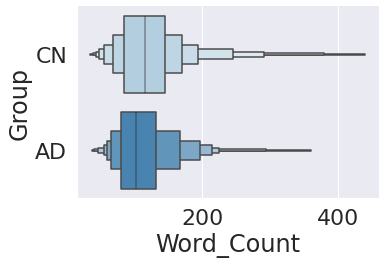

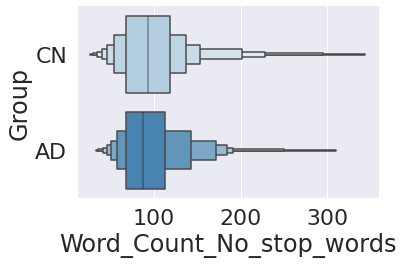

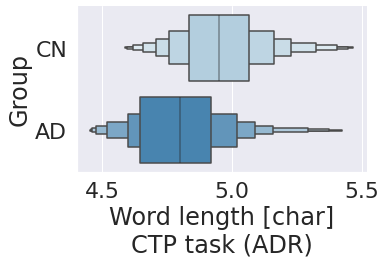

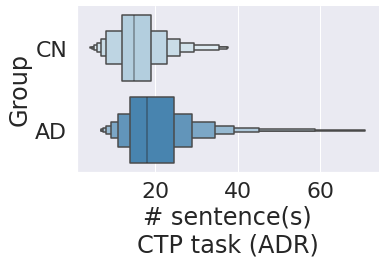

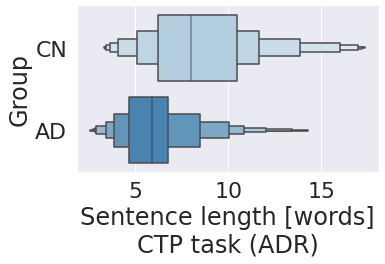

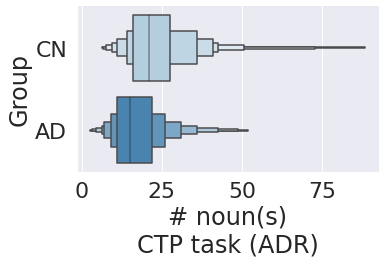

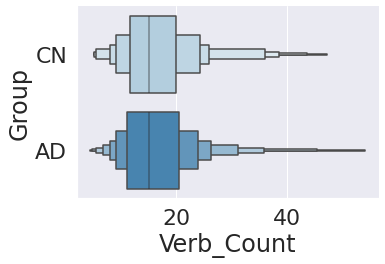

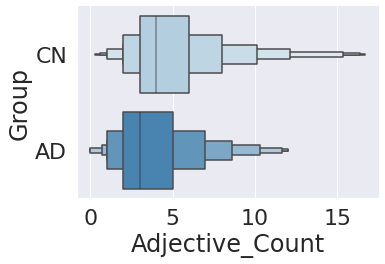

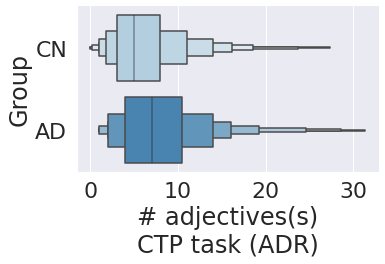

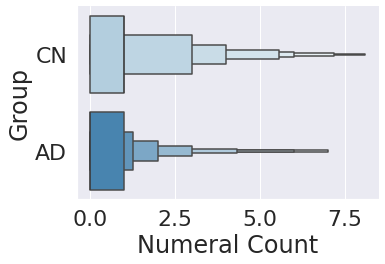

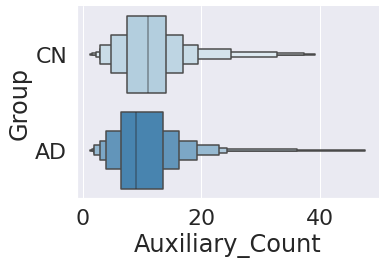

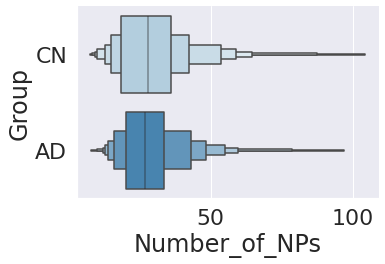

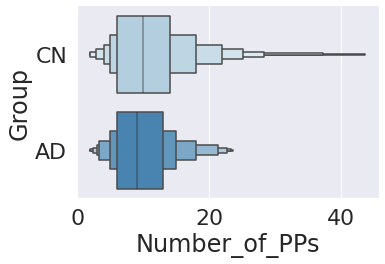

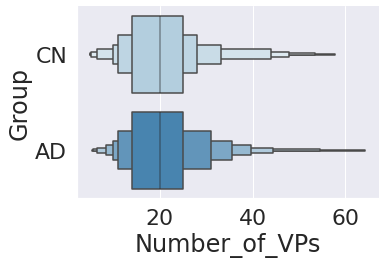

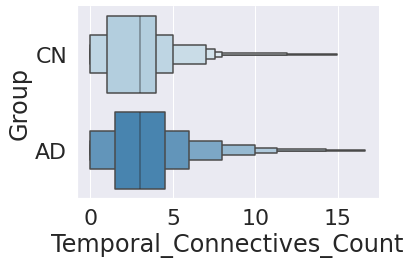

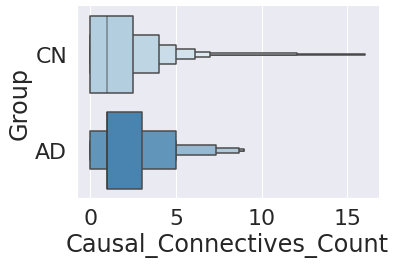

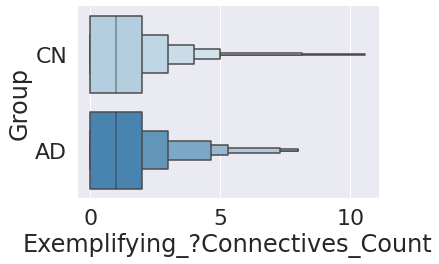

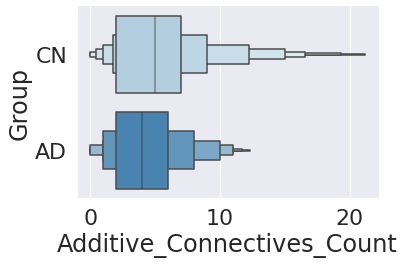

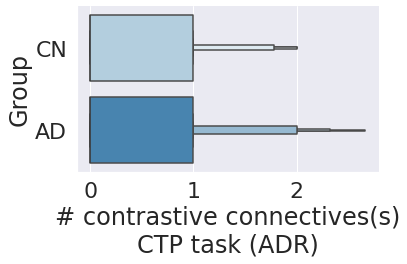

In [17]:
import seaborn as sns
for i, title in enumerate(task):  

    nome = title
   
    controls = []
   # parkinson=[]
    alz = []
   # ataxia = []
    #others= []
    
    data = np.concatenate([control_all_feat[i], alzheimer_all_feat[i]])
    data = data.tolist()

    [controls.append('CN') for value in range(len(control_all_feat[i]))]
   # [ataxia.append('ATX') for value in range(len(ataxia_all_feat[i]))]
   # [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    [alz.append('AD') for value in range(len(alzheimer_all_feat[i]))]
    #[others.append('OTR') for value in range(len(others_all_feat[i]))]

    lista = controls+alz
    
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    #tips = pd.DataFrame()
    #tips['task'] = data
    #tips['lista'] = lista
    
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)
    
    plt.savefig(f'/export/b14/afavaro/SLT_submission/Adress_plots/{nome}', facecolor='white', dpi=600)










## Box Plots Linguistic Feats

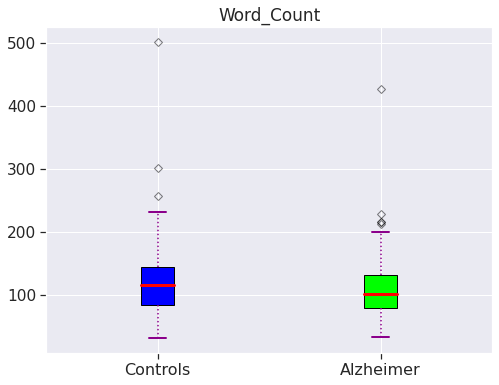

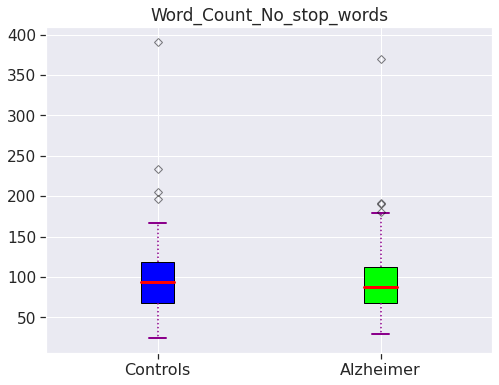

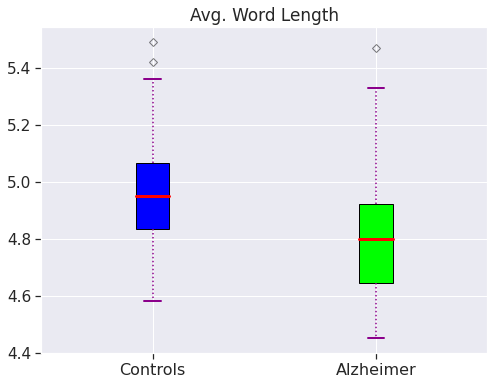

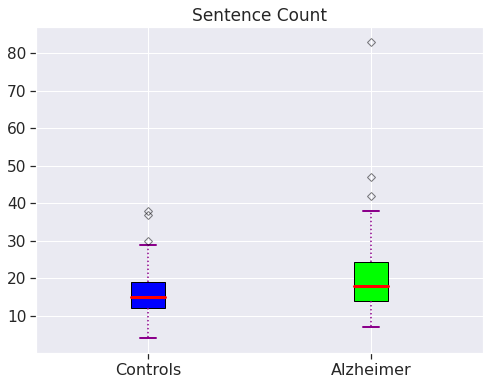

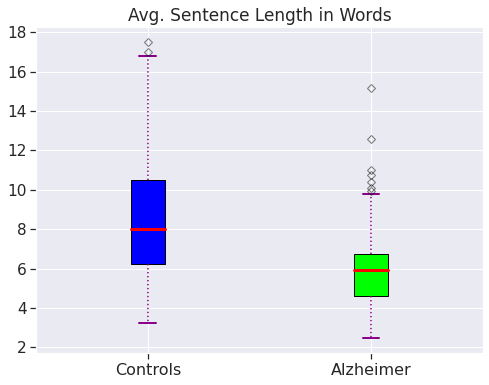

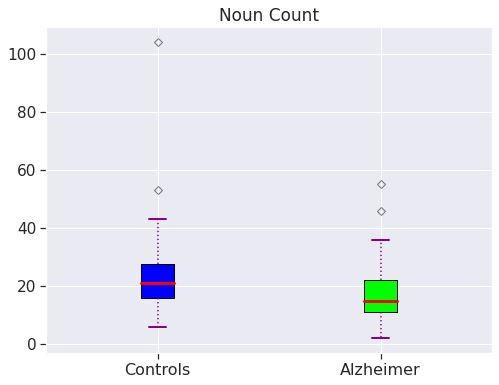

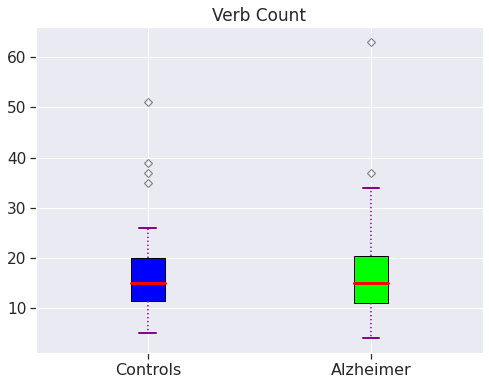

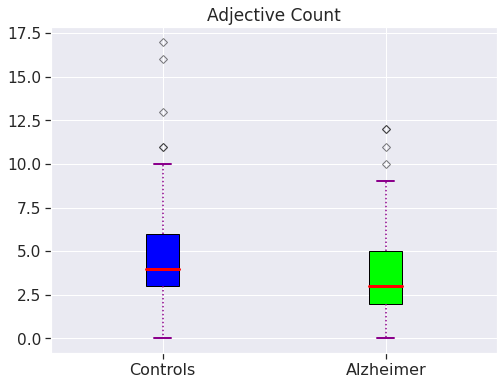

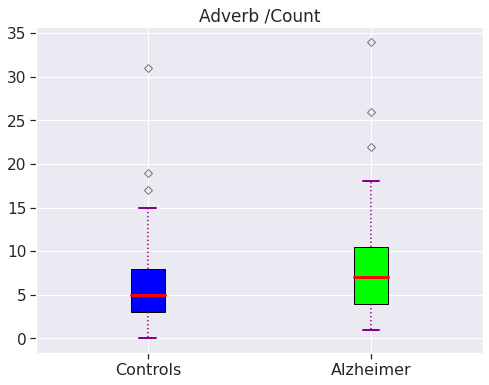

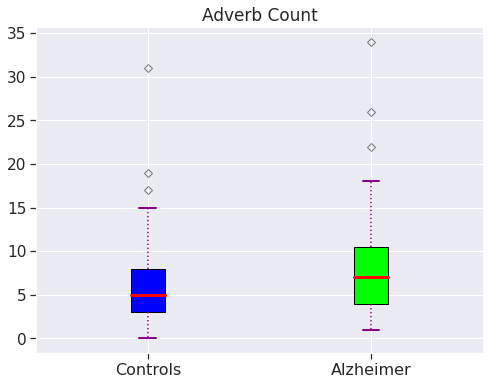

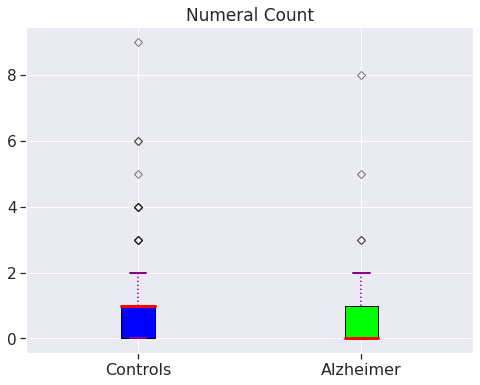

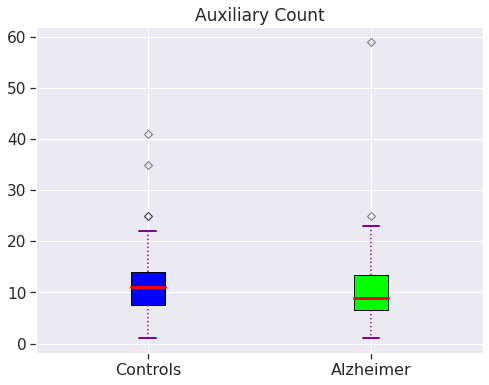

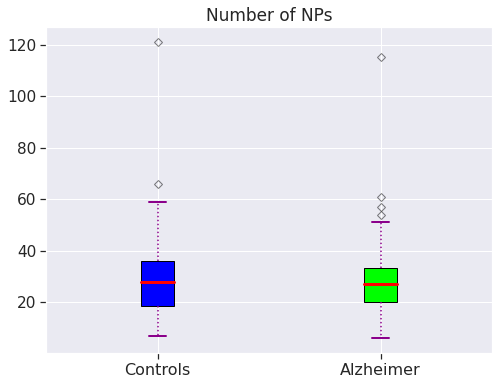

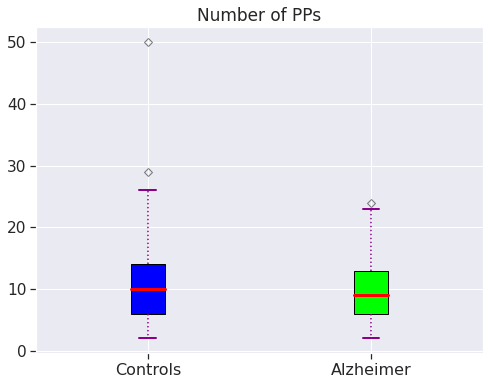

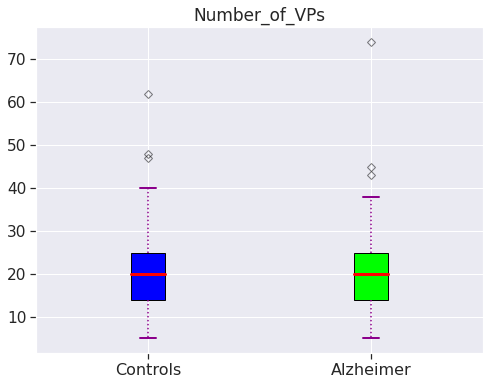

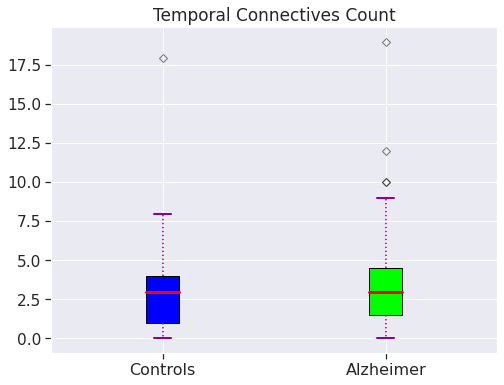

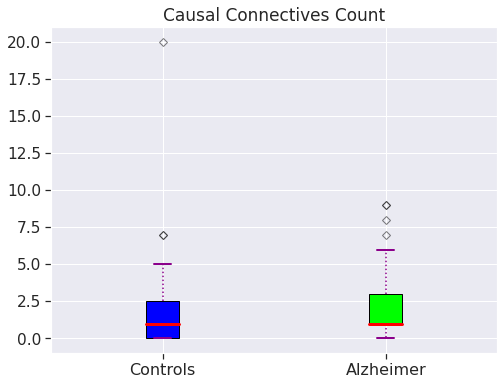

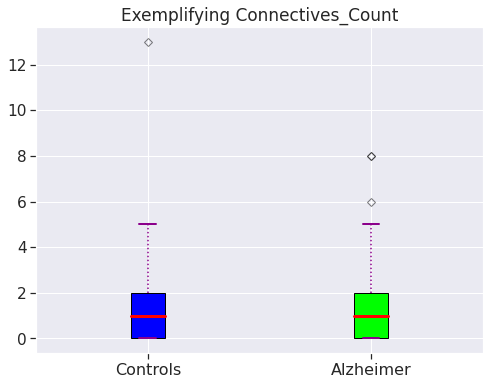

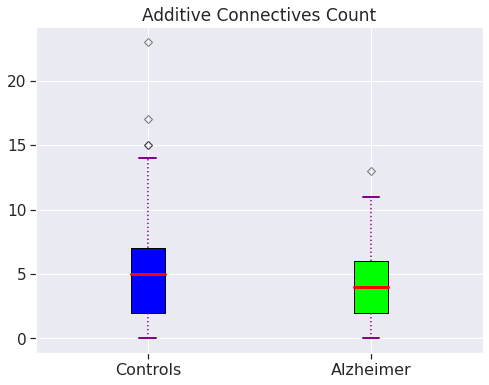

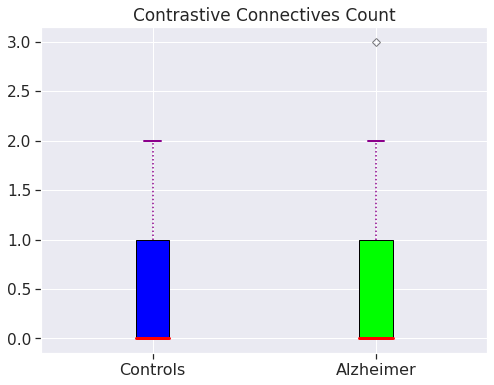

In [58]:
for i, title in enumerate(task):  
    nome = title
    data = [control_all_feat[i], alzhiemer_all_feat[i]]
#data = [control_all_feat[7], parkinson_all_feat[7], others_all_feat[7]]
#fig, ax = plt.subplots()

#ax.set_title('articulation_rate',  fontsize=18)
    labels = (['Controls', 'Alzheimers'])
    fig = plt.figure(figsize =(8, 6))
    ax = fig.add_subplot(111)
    #ax7.boxplot(data, widths = 0.4, patch_artist = False, labels=labels)

    #plt.figure(figsize=(7,6))
    # Creating axes instance
    bp = ax.boxplot(data, patch_artist =True,
                    notch =False, vert = 1)

    colors = ['#0000FF', '#00FF00']

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    #changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")

    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='red',
                   linewidth = 3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                  color ='#e7298a',
                  alpha = 0.5)

    # x-axis labels
    ax.set_xticklabels(['Controls', 'Alzheimer'], fontsize=16)

    # Adding title

    #for title in task:  
    plt.title(f'{nome}', fontsize=17)

    # Removing top axes and right axes
    # ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    #plt.savefig(f'/Users/annafavaro/Desktop/t-test/prosody_features/Plot/word_color/{nome}', dpi=300, bbox_inches='tight')
    # show plot
    plt.show(bp)

## Density Plots Linguistic Feats

https://www.geeksforgeeks.org/density-plots-with-pandas-in-python/

In [19]:

# histogram plot
from numpy.random import seed
from numpy.random import randn
from matplotlib import pyplot
# seed the random number generator
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

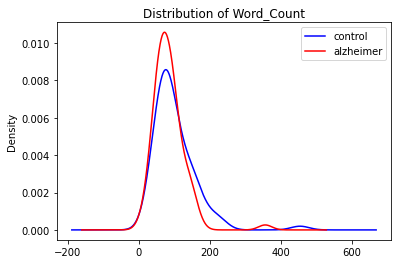

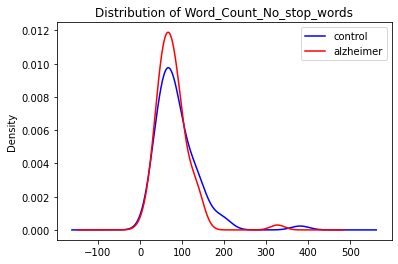

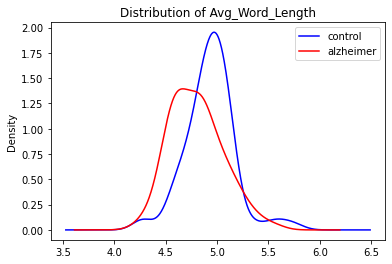

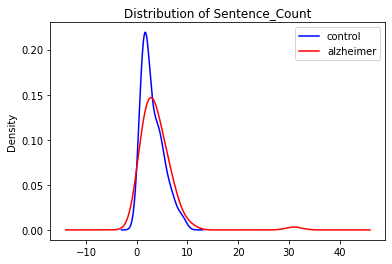

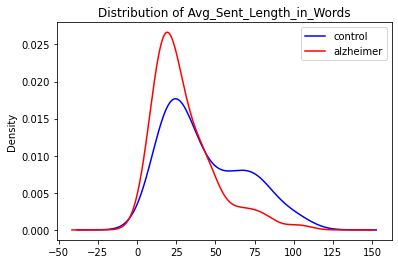

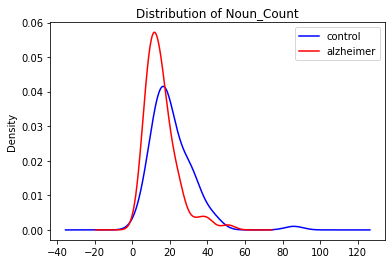

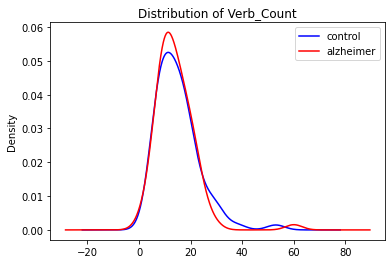

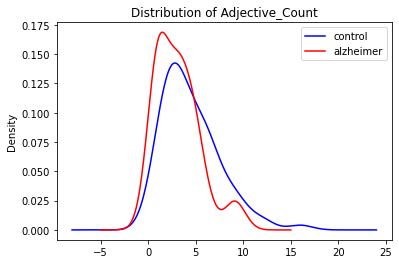

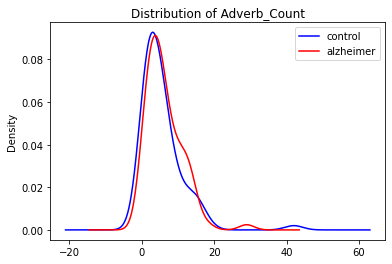

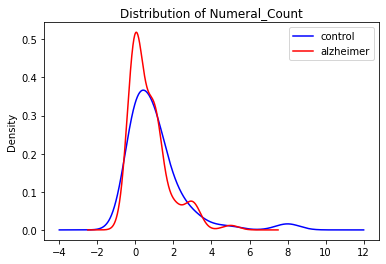

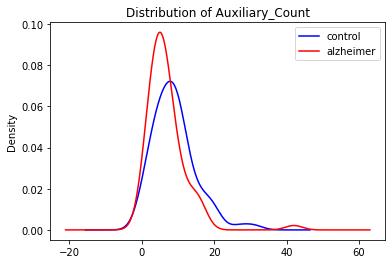

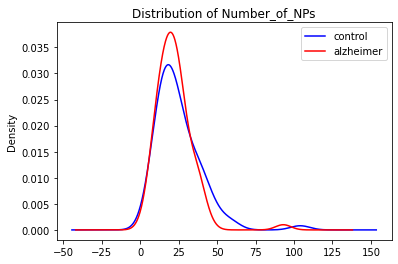

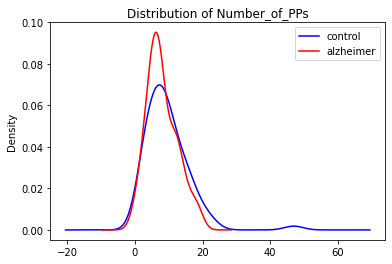

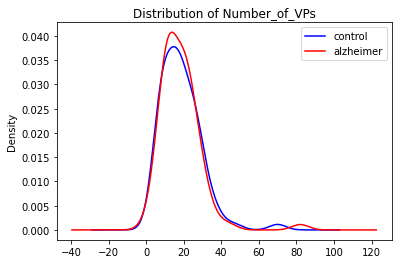

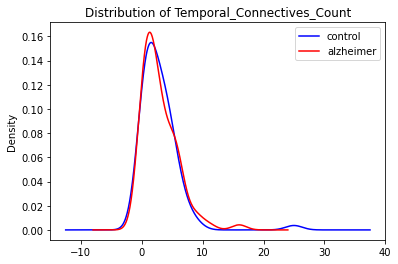

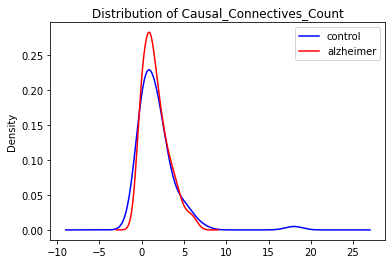

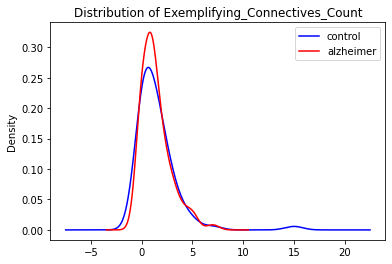

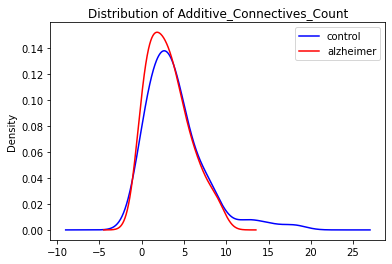

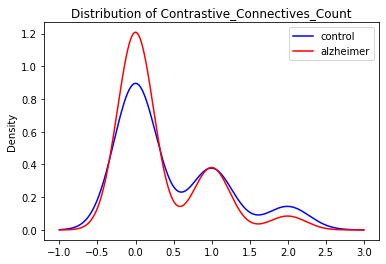

In [20]:
for i, title in enumerate(task):  
    
    nome = title
    data = [control_all_feat[i], alzhiemer_all_feat[i]]

    df = pd.DataFrame()
    data = [control_all_feat[i], alzhiemer_all_feat[i]]
    df['control'] = pd.Series(data[0])
    df['alzheimer'] = pd.Series(data[1]) 

    fig, ax = plt.subplots(1,1)
    colors = ['blue', 'red']
    for s, col in zip(df.columns, colors):
        df[s].plot(kind='density', color=col)
    plt.legend()
    plt.title(f'Distribution of {nome}')
   # plt.xlabel(f'{nome}')
    fig.show()


In [81]:
79 + 87 

166

In [ ]:
(H - k + 1)/(n - k)

In [82]:
(5.09 - 1)/(166-2)

0.0249390243902439

In [116]:
(27.90  - 1)/(166-2)

0.16402439024390242

In [115]:
(32.74 - 1)/(166-2)

0.19353658536585366